In [1]:
from TabDAE.tab_dae import DenoisingAutoencoder

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

## Problem definition

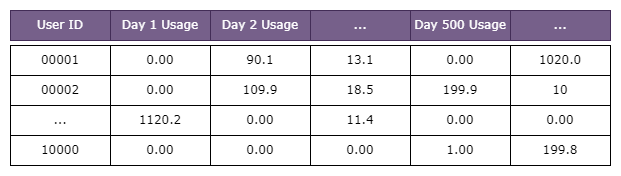

Say we have 10,000 customer's usage data for past 500 Days. And we need to build usage forecasting model for this 10,000 users. But in some cases all usaers don't nessasaryly want machine learning methods. Instead we can use simple rule for some customer segment. But the situation is quite complex in some customer segments, their usage is hard to predict with simple rules, in such a case we have to use machine learning. But how do we distinguish those customer segments? That's where segmentation comes into a play. 

In this notebook. we will build time series clustering model to identify above mentioned customer segments. Dataset used here represent the real customer usage dataset extracted between 2020/2021. Let's begin.

In [2]:
usage_data = pd.read_parquet("usage_data/sample_10_000_preprocessed.parquet")

In [3]:
usage_data.columns = ['uid','usage']

In [4]:
usage_data_pivot = usage_data.pivot_table(
    values='usage',
    index='uid',
    columns=usage_data.index
)

In [5]:
usage_data_pivot.shape

(10000, 579)

In [6]:
usage_data_pivot.head()

,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,...,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-26,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
uid,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,255,0,0,0,0,0,176,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1100,1726,1243,1426,1366,1215,859,1772,0,1099
3,0,0,0,0,0,0,0,0,0,0,...,341,647,634,46,32,284,374,451,0,1006
4,0,0,0,0,0,0,0,0,0,0,...,304,0,323,88,22,295,413,392,0,114


In [7]:
usage_data_pivot.columns = list(
    range(
        len(
            usage_data_pivot.columns
            )
        )
    )

In [8]:
del usage_data

In [9]:
usage_data_pivot.replace(0,1e-4,inplace=True)
usage_data_pivot.head()

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,578
uid,,,,,,,,,,,,,,,,,,,,,
0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,255.0000,0.0001,0.0001,0.0001,0.0001,0.0001,176.0000,0.0001,0.0001
2,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,1100.0000,1726.0000,1243.0000,1426.0000,1366.0000,1215.0000,859.0000,1772.0000,0.0001,1099.0000
3,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,341.0000,647.0000,634.0000,46.0000,32.0000,284.0000,374.0000,451.0000,0.0001,1006.0000
4,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,304.0000,0.0001,323.0000,88.0000,22.0000,295.0000,413.0000,392.0000,0.0001,114.0000


Here I'm deviding each users's usage by his/her maximum usage in given 579 days. Now I have 0-1 normalized value for each user. Since my target is identifying users with similar usage pattern (not the usage quantity) I guess it'll be more meaningful.

In [10]:
normalize = lambda row: (row / row.max())

In [11]:
usage_normalized = usage_data_pivot.apply(normalize, axis=1)

In [12]:
usage_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,578
uid,,,,,,,,,,,,,,,,,,,,,
0,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,...,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08,3.885004e-08
1,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,...,2.524615e-08,6.437768e-02,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,2.524615e-08,4.443322e-02,2.524615e-08,2.524615e-08
2,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,1.759944e-08,...,1.935938e-01,3.037663e-01,2.187610e-01,2.509680e-01,2.404083e-01,2.138332e-01,1.511792e-01,3.118620e-01,1.759944e-08,1.934178e-01
3,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,1.786671e-08,...,6.092550e-02,1.155976e-01,1.132750e-01,8.218689e-03,5.717349e-03,5.074147e-02,6.682151e-02,8.057888e-02,1.786671e-08,1.797391e-01
4,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,1.980198e-08,...,6.019802e-02,1.980198e-08,6.396040e-02,1.742574e-02,4.356436e-03,5.841584e-02,8.178218e-02,7.762376e-02,1.980198e-08,2.257426e-02


Plot sample usage pattern

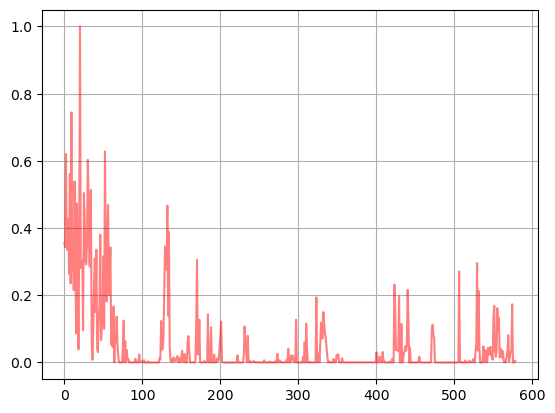

In [13]:
usage_normalized.iloc[999].plot(alpha=0.5,color='r')
plt.grid(True)
plt.show()

Let's train the model. Please note the output layer activation function used here. It's `RelU (Rectified Linear Unit)` . I used it because customer usage data always be either 0 or positive. If we use another activation functions such as `Logistic` it may return negetive values and it's meaning-less for this specific problem. If you want to know more info about model architecture, please refre to [this](https://github.com/Ransaka/TabDAE) code repo. It containes all the infomation related to above model archtecture. Finally I have used `MAE` as loss function here.

In [14]:
# Split the data into train and test sets
train_data, test_data = train_test_split(usage_normalized, test_size=0.2)

# Convert the data to a PyTorch tensor
train_data = torch.tensor(train_data.values).float()
test_data = torch.tensor(test_data.values).float()

# Define the model, optimizer, and loss function
input_dim = usage_normalized.shape[1]
encoding_dim = 64
hidden_dims = [512 ,256, 128]
model = DenoisingAutoencoder(input_dim, hidden_dims, encoding_dim,dropout_rate=0.1,activation=nn.ReLU,output_activation=nn.ReLU)
optimizer = optim.Adam(model.parameters(),lr=1e-2)
loss_fn = nn.L1Loss()

# Train the model
batch_size = 5000
num_epochs = 20
for epoch in range(num_epochs):
    # Iterate over the training data in batches
    for i in range(0, len(train_data), batch_size):
        inputs = train_data[i:i+batch_size]
        # Forward pass
        output = model(inputs, add_noise=True)
        loss = loss_fn(output, inputs)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
    model.eval()
    
    test_loss = 0
    for i in range(0, len(test_data), batch_size):
        inputs = test_data[i:i+batch_size]
        output = model(inputs, add_noise=False)
        test_loss += loss_fn(output, inputs).item()
    test_loss /= len(test_data)
    print(f'Test loss: {test_loss:.5f}')
    
# switch back to train mode    
    model.train()

Test loss: 0.00008
Test loss: 0.00017
Test loss: 0.00019
Test loss: 0.00028
Test loss: 0.00029
Test loss: 0.00027
Test loss: 0.00021
Test loss: 0.00017
Test loss: 0.00013
Test loss: 0.00010
Test loss: 0.00009
Test loss: 0.00007
Test loss: 0.00006
Test loss: 0.00006
Test loss: 0.00006
Test loss: 0.00006
Test loss: 0.00005
Test loss: 0.00005
Test loss: 0.00005
Test loss: 0.00005


Let's plot sample recostructed and actual usage data. To get reconstructed data we have to send our data throuhout both encoder and decoder. We can simply use `model(input_tensor_dataset)` for that. After that I have plot the reconstructed datasets with it's original shape.

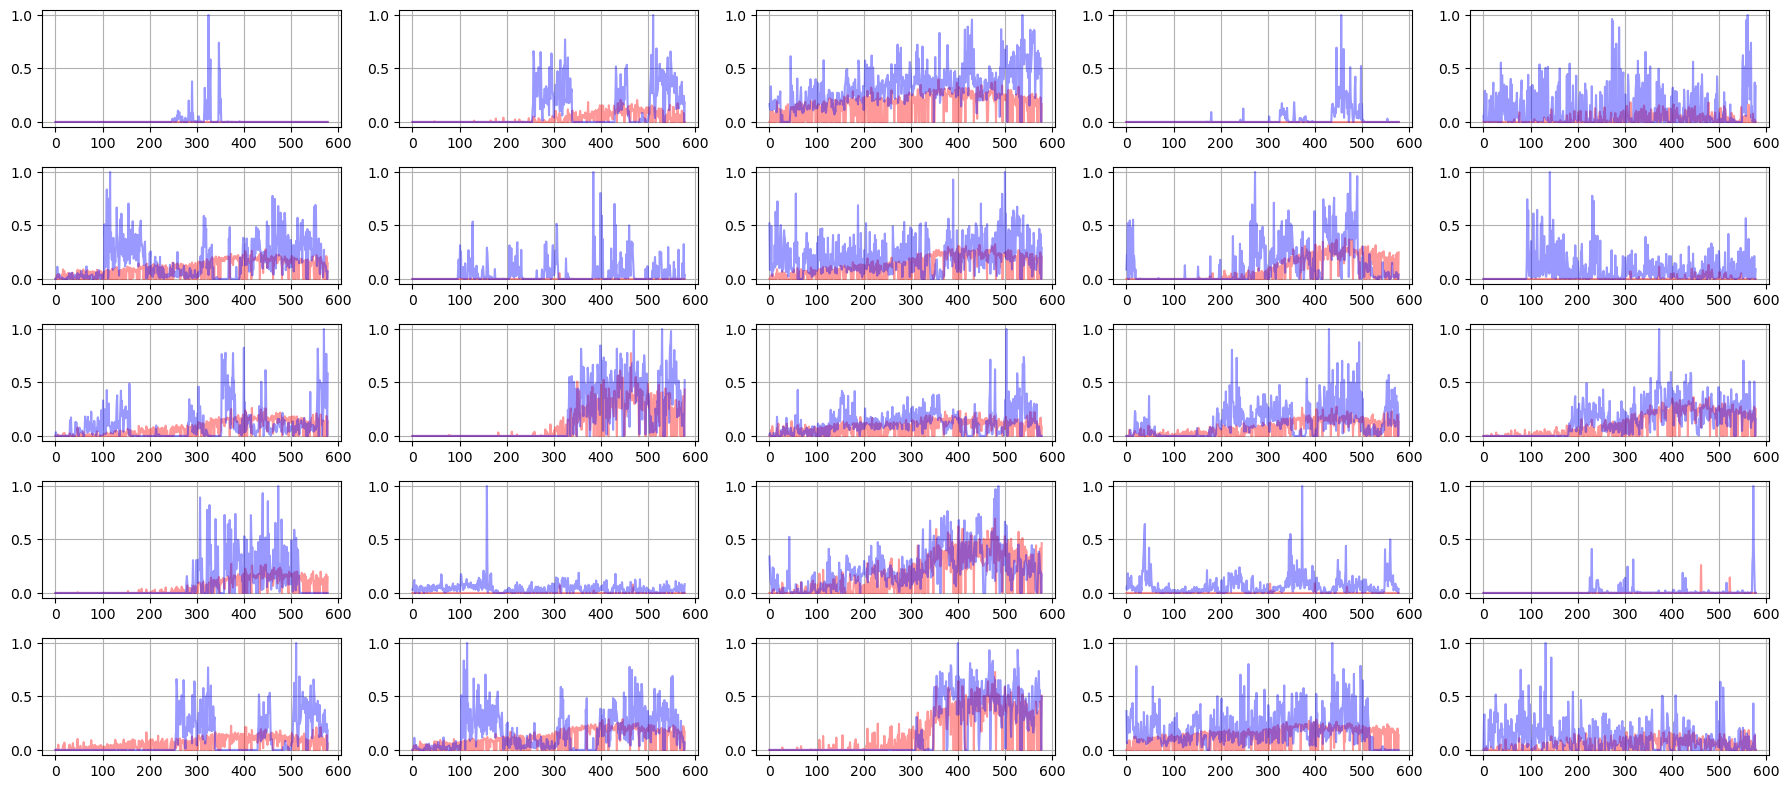

In [15]:
# Set the number of rows and columns
n_rows = 5
n_cols = 5

# Set the figure size and create the figure
plt.figure(figsize=(18, 8))

for i in range(n_rows):
    for j in range(n_cols):
        # Select a random index from the test data
        rand_id = np.random.choice(list(range(len(test_data))))

        # Get the original and sample data at the selected index
        original_data = test_data[rand_id].detach().numpy()
        constructed_data = model(test_data)[rand_id].detach().numpy()

        # Plot the original and sample data in the current subplot
        plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
        plt.plot(constructed_data, color='red',alpha=0.4)
        plt.plot(original_data, color='blue',alpha=0.4)
        plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Alright, now we almost completed the denoicing part. Now we have clustering part left. Let's start with clustering.

These are the steps I follow,
 1. Fit the `KMeans` algorithms for original dataset and get the labels.
 2. Perform `PCA` on dataset and project dataset into 2d pane by using first 2 component of the PCA
 
This will repeat for the reconstructed data as well.

In [16]:
from plotting.plotting_utils import plot_kmeans_pca,plot_time_series

In [17]:
N_CLUSTERS = 5

Let's start with original dataset

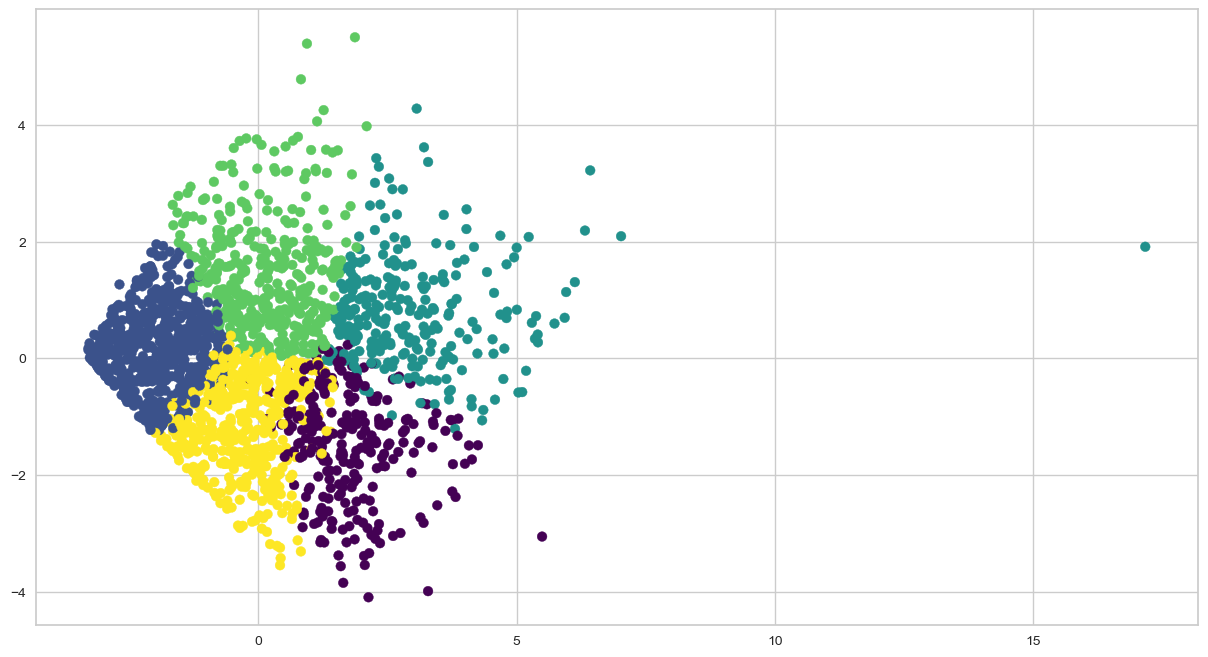

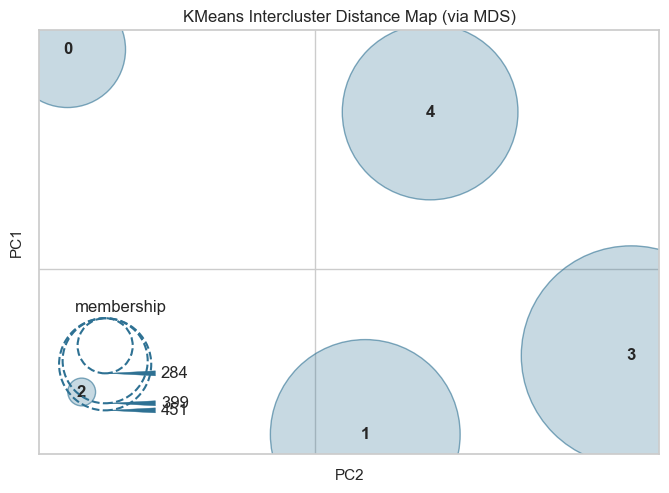

In [18]:
test_data_npy = test_data.detach().numpy()
labels = plot_kmeans_pca(test_data_npy,n_clusters=N_CLUSTERS)

Okay, now we have assigned each customers into segmentation based on their usage trend. Now it's time to plot sample dataset for each customer segment.

In [19]:
clustered_df = pd.DataFrame(
    test_data_npy
)

clustered_df['cluster'] = labels

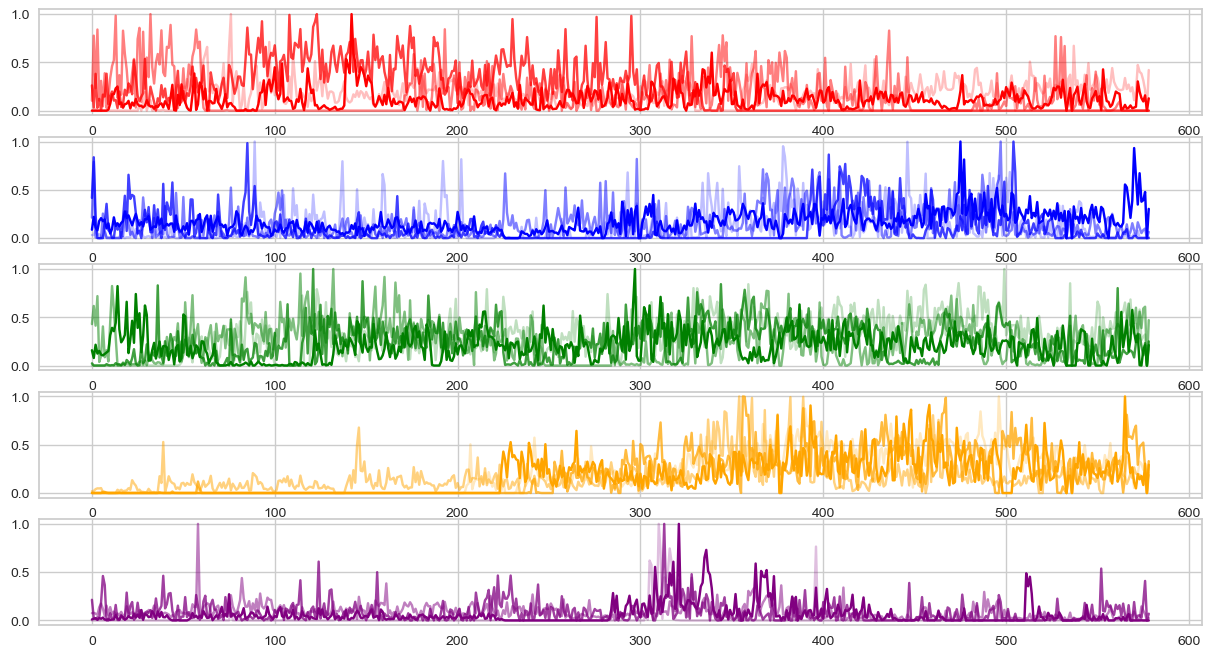

In [20]:
plot_time_series(clustered_df)

After looking at above generated plot you may notice some reasonabl segmentation happend there. 

As an example, 
- Red segment users and green segment users have most inactive days. 
- Blue segement customers are relatively inactive in begining of the series and then they have gradually increased their usage over time.
- Orange and Purple users have relatively active pattern among other segmants. Among these two segments, the Orange group has the most active behavour compared to the Purple segment.

Let's repeat the same for reconstructed dataset as well.

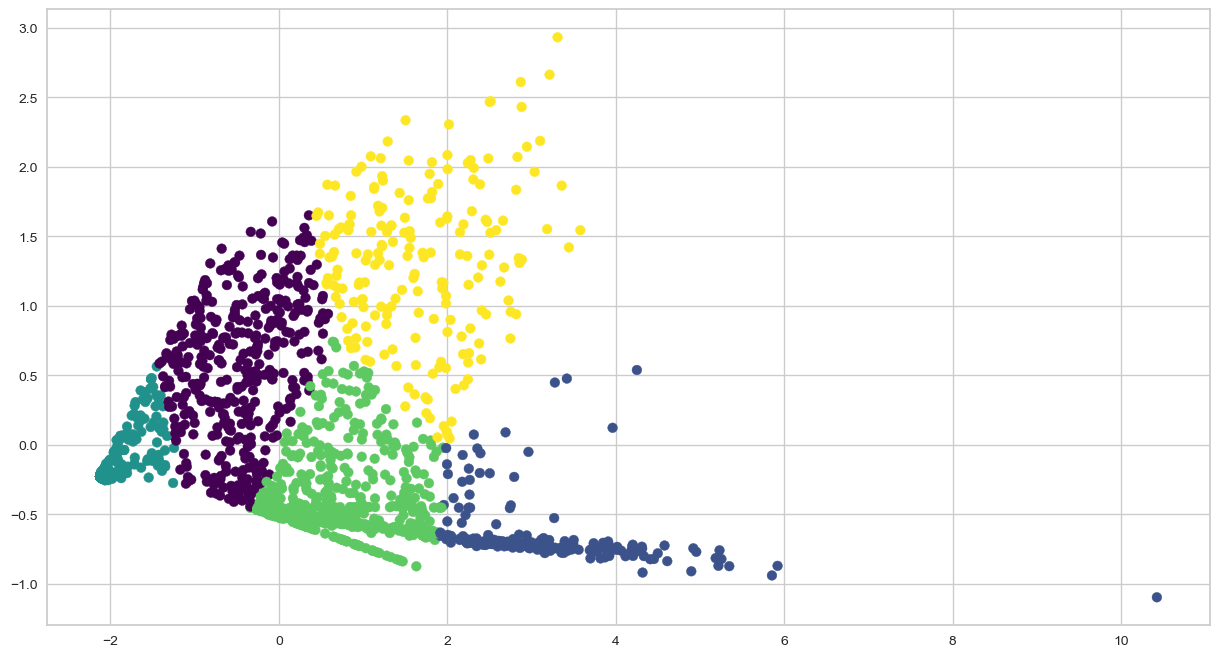

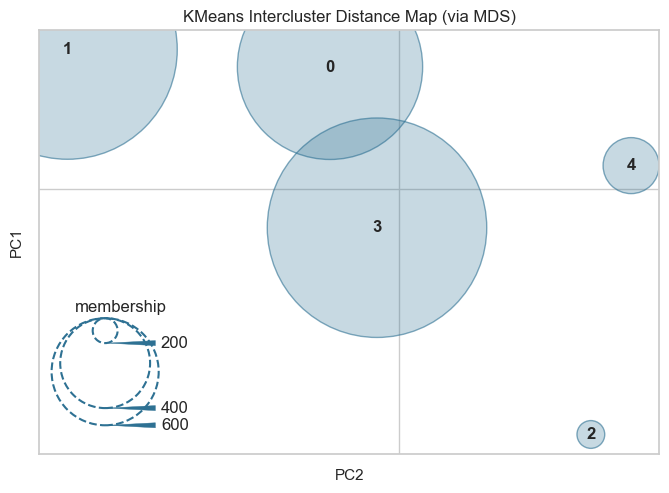

In [21]:
test_reconstructed = model(test_data).detach().numpy()
labels = plot_kmeans_pca(test_reconstructed,n_clusters=N_CLUSTERS)

In [22]:
reconstructed_clustered_df = pd.DataFrame(
    test_data_npy
)

reconstructed_clustered_df['cluster'] = labels

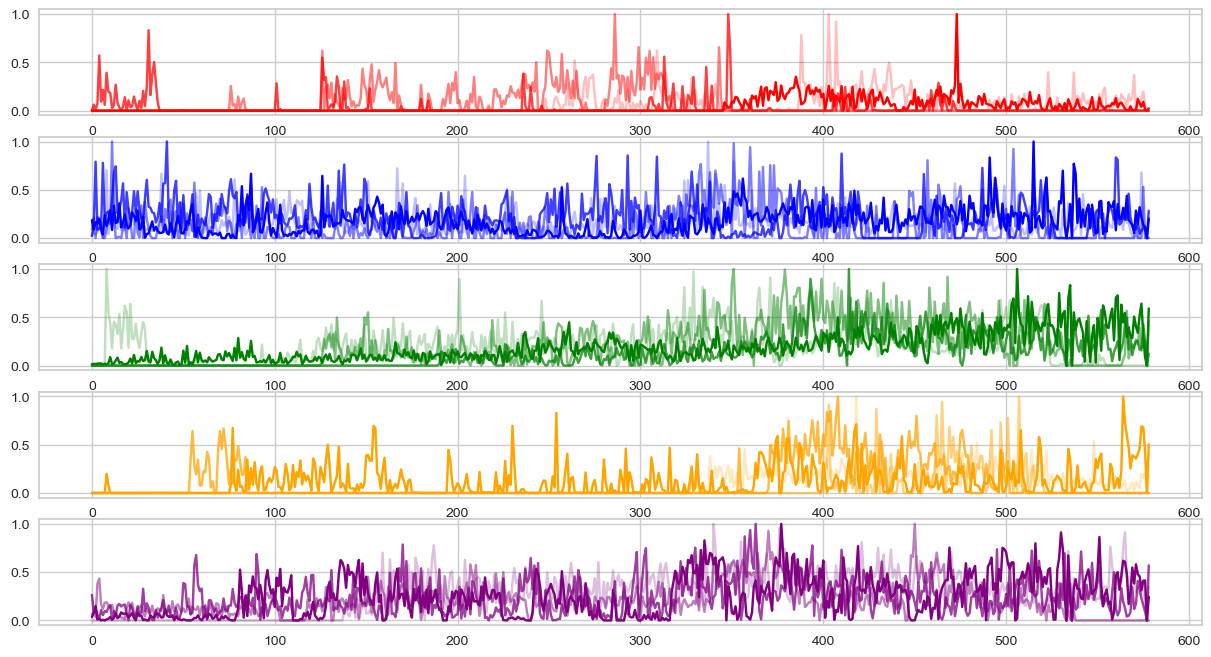

In [23]:
plot_time_series(reconstructed_clustered_df)

Alright, that's for the original and recostructed data. Let's repeat the above experiments for latent dataset as well. To get the latent representation we can simply access the model's `encoder` part using `model.encoder()`. Let's do that.

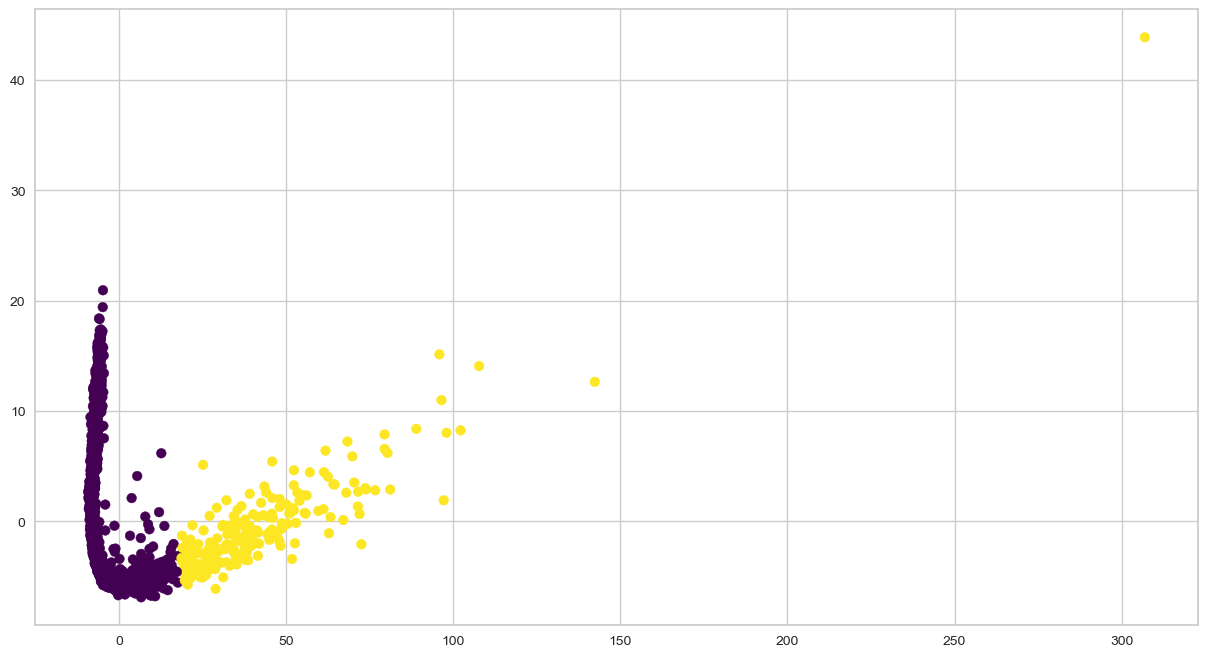

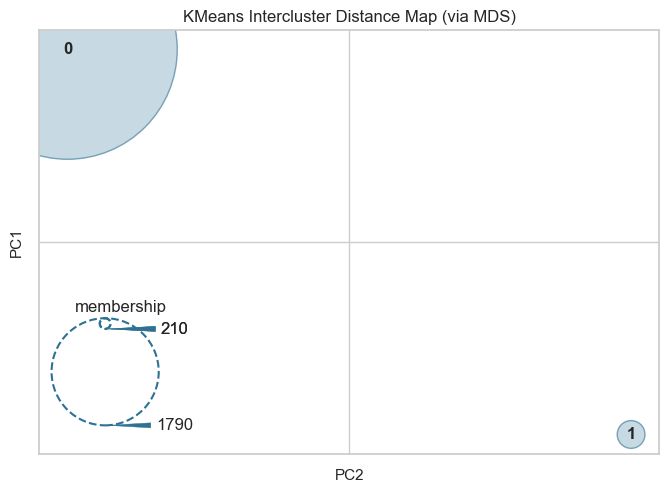

In [47]:
test_latent_data = model.encoder(test_data).detach().numpy()
labels = plot_kmeans_pca(test_latent_data,n_clusters=2)

In [48]:
latent_clustered_df = pd.DataFrame(
    test_data_npy
)

latent_clustered_df['cluster'] = labels

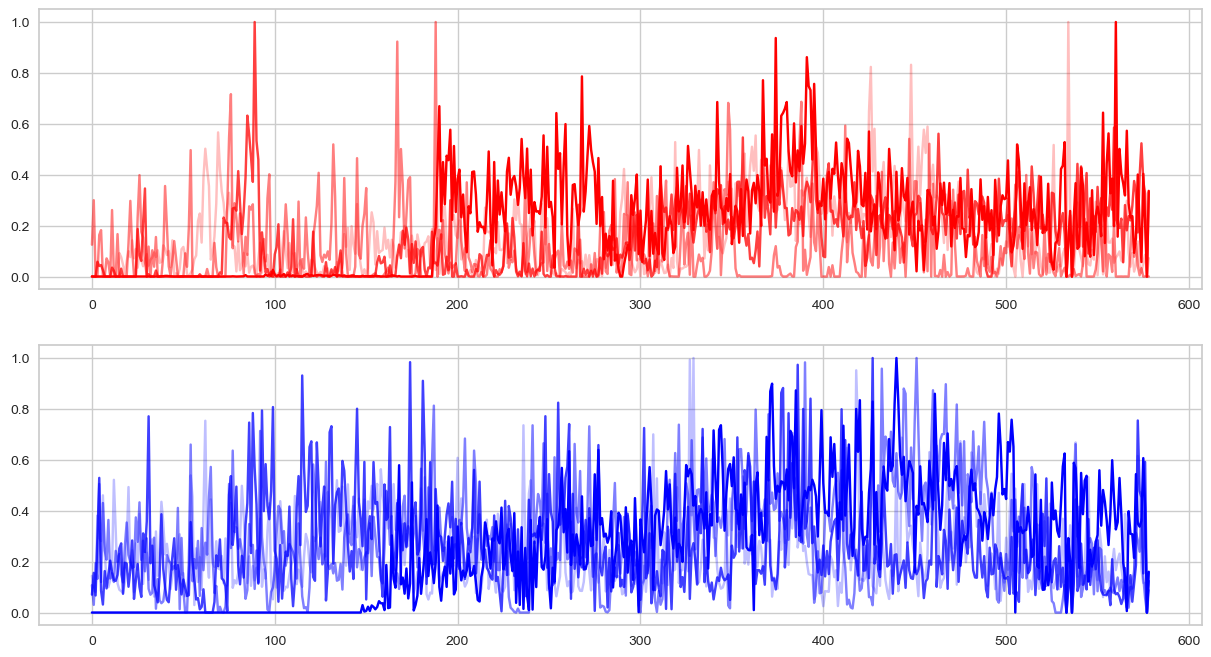

In [49]:
plot_time_series(latent_clustered_df)